## CUDA and SPLIT


In [2]:

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.empty_cache()
SPLIT_BY = 'actor'

## normalize

In [3]:
from statMLlib import DatasetWrapper 
import imp
imp.reload(DatasetWrapper)
from statMLlib.DatasetWrapper import RAVDESSFeatureDataset
from torch.utils.data import DataLoader

class StatsRecorder:
    def __init__(self, red_dims=(0,1,2)):
        """Accumulates normalization statistics across mini-batches.
        ref: http://notmatthancock.github.io/2017/03/23/simple-batch-stat-updates.html
        """
        self.red_dims = red_dims # which mini-batch dimensions to average over
        self.nobservations = 0   # running number of observations

    def update(self, data):
        """
        data: ndarray, shape (nobservations, ndimensions)
        """
        # initialize stats and dimensions on first batch
        if self.nobservations == 0:
            self.mean = data.mean(dim=self.red_dims, keepdim=True)
            self.std  = data.std (dim=self.red_dims,keepdim=True)
            self.nobservations = data.shape[0]
            self.ndimensions   = data.shape[1]
        else:
            if data.shape[1] != self.ndimensions:
                raise ValueError('Data dims do not match previous observations.')
            
            # find mean of new mini batch
            newmean = data.mean(dim=self.red_dims, keepdim=True)
            newstd  = data.std(dim=self.red_dims, keepdim=True)
            
            # update number of observations
            m = self.nobservations * 1.0
            n = data.shape[0]

            # update running statistics
            tmp = self.mean
            self.mean = m/(m+n)*tmp + n/(m+n)*newmean
            self.std  = m/(m+n)*self.std**2 + n/(m+n)*newstd**2 +\
                        m*n/(m+n)**2 * (tmp - newmean)**2
            self.std  = torch.sqrt(self.std)
                                 
            # update total number of seen samples
            self.nobservations += n


root_features='/home/spongebob*/statML_project/RAVDESS/RAVDESS-emotions-speech-audio-only-master/Audio_Speech_Actors_01-24/FeaturesAll/'

train_iter = RAVDESSFeatureDataset(split='train',split_by=SPLIT_BY, root_dir=root_features)#Multi30k(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
train_dataloader = DataLoader(train_iter, batch_size=8, shuffle=True)

# create recorders
global_stats  = StatsRecorder()
channel_stats = StatsRecorder(red_dims=(0,2))

# step through the training dataset
with torch.no_grad():
    for idx,(x,y) in enumerate(iter(train_dataloader)):
        # print(x.shape)
        # print((torch.mean(x, axis=1)))
        # update normalization statistics
        # x=(x-torch.mean(x))/torch.std(x)
        global_stats.update(x)
        channel_stats.update(x)
    
# parse out both sets of stats
global_mean,global_std = global_stats.mean,global_stats.std
global_mean=global_mean.squeeze(0)
global_std=global_std.squeeze(0)


channel_mean,channel_std = channel_stats.mean,channel_stats.std
channel_mean=channel_mean.squeeze(0)
channel_std=channel_std.squeeze(0)

print(f'Shape of global mean: {global_mean.shape}')
print(f'Shape of global standard dev: {global_std.shape}')

print(f'Shape of channel mean: {channel_mean.shape}')
print(f'Shape of channel standard dev: {channel_std.shape}')
# print(channel_mean)
global_mean.to(DEVICE)
global_std.to(DEVICE)

channel_mean.to(DEVICE)
channel_std.to(DEVICE)

# print(channel_mean)
pass


Shape of global mean: torch.Size([1, 1])
Shape of global standard dev: torch.Size([1, 1])
Shape of channel mean: torch.Size([131, 1])
Shape of channel standard dev: torch.Size([131, 1])


## check sample

torch.Size([16, 131, 81])
tensor(-0.0275, device='cuda:0')


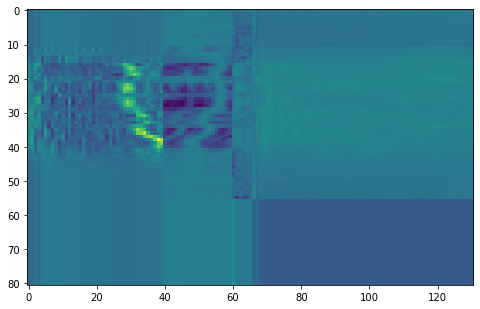

In [4]:
from statMLlib import DatasetWrapper 
import imp
imp.reload(DatasetWrapper)
from statMLlib.DatasetWrapper import RAVDESSFeatureDataset


from torch.utils.data import DataLoader
import matplotlib.pyplot as plt 

root_features='/home/spongebob*/statML_project/RAVDESS/RAVDESS-emotions-speech-audio-only-master/Audio_Speech_Actors_01-24/FeaturesAll/'

train_iter = RAVDESSFeatureDataset(split='train',split_by=SPLIT_BY, root_dir=root_features, mean=channel_mean, std= channel_std)#Multi30k(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
train_dataloader = DataLoader(train_iter, batch_size=BATCH_SIZE, shuffle=True)

for src, tgt in train_dataloader:
    src = src.to(DEVICE)
    tgt = tgt.to(DEVICE)
    
    print(src.shape)
#     print(tgt.shape)
#     print(torch.mean(src, axis=1).shape)
    

    print(torch.mean(src[0][0]))
    fig=plt.figure(figsize=(8, 8))
    # plt.plot(src.cpu().numpy()[1])
    imgplot = plt.imshow(src.cpu().numpy()[1].T)
    
#     print(std)
#     print(src_norm.cpu().numpy()[5].T)

    break
    
    





## Train Eval functions

In [6]:
from torch.utils.data import DataLoader
from statMLlib.DatasetWrapper import RAVDESSFeatureDataset

root_features='/home/spongebob*/statML_project/RAVDESS/RAVDESS-emotions-speech-audio-only-master/Audio_Speech_Actors_01-24/FeaturesAll/'

def train_epoch(model, optimizer):
    model.train()
    losses = 0

    train_iter = RAVDESSFeatureDataset(split='train',split_by=SPLIT_BY, root_dir=root_features, mean=MEAN, std= STD)#Multi30k(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
    train_dataloader = DataLoader(train_iter, batch_size=BATCH_SIZE, shuffle=True)
    
    for src, tgt in train_dataloader:
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)
        
#         if(NORM=='channel'):
#             mean=channel_mean.repeat(src.shape[0],1,src.shape[2]).to(DEVICE)
#             std=channel_std.repeat(src.shape[0],1,src.shape[2]).to(DEVICE)
        
#         elif NORM == 'global':
#             mean=global_mean.repeat(src.shape[0],src.shape[1],src.shape[2]).to(DEVICE)
#             std=global_std.repeat(src.shape[0],src.shape[1],src.shape[2]).to(DEVICE)
            
#         else:
#             mean=torch.tensor(0).to(DEVICE)
#             std=torch.tensor(1).to(DEVICE)
            
#         # src=(src-torch.mean(src, axis=1))/torch.std(src, axis=1)
#         src_norm=(src-mean)/std
        
        logits = model(src)
        # print(logits.shape)

        optimizer.zero_grad()
        
       

        loss = loss_fn(logits, tgt)
        # print(loss)
        # loss = loss_fn(logits, tgt_out)

        loss.backward()

        optimizer.step()
        losses += loss.item()

    return losses / len(train_dataloader)


def evaluate(model):
    model.eval()
    losses = 0

    
    val_iter = RAVDESSFeatureDataset(split='valid',split_by=SPLIT_BY, root_dir=root_features, mean=MEAN, std= STD)#Multi30k(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
    val_dataloader = DataLoader(val_iter, batch_size=BATCH_SIZE, shuffle=True)
    
    for src, tgt in val_dataloader:
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)
        
#         if NORM=='channel':
#             mean=channel_mean.repeat(src.shape[0],1,src.shape[2]).to(DEVICE)
#             std=channel_std.repeat(src.shape[0],1,src.shape[2]).to(DEVICE)
        
#         elif NORM == 'global':
#             mean=global_mean.repeat(src.shape[0],src.shape[1],src.shape[2]).to(DEVICE)
#             std=global_std.repeat(src.shape[0],src.shape[1],src.shape[2]).to(DEVICE)
            
#         else:
#             mean=torch.tensor(0).to(DEVICE)
#             std=torch.tensor(1).to(DEVICE)
            
#         # src=(src-torch.mean(src))/torch.std(src)
#         src_norm=(src-mean)/std

        logits = model(src)
  
        loss = loss_fn(logits, tgt)
     
        losses += loss.item()
    
    
    
    return losses / len(val_dataloader)

# MLP

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Ravdess_MLP(nn.Module):

    def __init__(self, input_size, tgt_class_cnt, num_of_layers):
        super(Ravdess_MLP, self).__init__()
        # an affine operation: y = Wx + b
        self.input_size=input_size
        self.tgt_class_cnt=tgt_class_cnt
        
        self.hidden_dim=int(self.input_size/2)
                               
        self.linear_relu_stack1 = nn.Sequential(

            nn.Linear(input_size, input_size),
            nn.BatchNorm1d(input_size),
            nn.ReLU(),
            # nn.Dropout(0.2),
            
            nn.Linear(input_size, self.hidden_dim),
            nn.BatchNorm1d(self.hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.1),
        )
        
        self.hidden = []
        for k in range(num_of_layers):
            self.hidden.append(nn.Linear(self.hidden_dim, self.hidden_dim))
            self.hidden.append(nn.BatchNorm1d(self.hidden_dim))
            self.hidden.append(nn.ReLU())
            # self.hidden.append(nn.Dropout(0.1))

       
        self.linear_relu_stack2 = nn.Sequential(*self.hidden)
        
        self.linear_relu_stack3 = nn.Sequential(
  
            nn.Linear(self.hidden_dim, int(self.hidden_dim/2)),
            nn.BatchNorm1d(int(self.hidden_dim/2)),
            nn.ReLU(),
            nn.Dropout(0.2),
            
            nn.Linear(int(self.hidden_dim/2), int(self.hidden_dim/4)),
            nn.BatchNorm1d(int(self.hidden_dim/4)),
            nn.ReLU(),
            # nn.Dropout(0.2),
            
            nn.Linear(int(self.hidden_dim/4), int(self.hidden_dim/8)),
            nn.BatchNorm1d(int(self.hidden_dim/8)),
            nn.ReLU(),
            nn.Dropout(0.1),
            
            nn.Linear(int(self.hidden_dim/8), tgt_class_cnt)
  
#             nn.Dropout(0.5),
           

        )
   
    def forward(self, x):
       
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        x = self.linear_relu_stack1(x)
        x = self.linear_relu_stack2(x)
        x = self.linear_relu_stack2(x)
        

        return x




In [7]:
from torchsummary import summary

INPUT_SIZE=131*81
TGT_CLASS_CNT=8
BATCH_SIZE = 16 #128

mlp = Ravdess_MLP(input_size=INPUT_SIZE, tgt_class_cnt=TGT_CLASS_CNT, num_of_layers=2)
# print(mlp)
# params = list(mlp.parameters())
# print(len(params))
# print(params[0].size())  # conv1's .weight

summary(mlp)

for p in mlp.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

mlp = mlp.to(DEVICE)

# loss_fn = torch.nn.KLDivLoss(reduction='batchmean')
loss_fn = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(mlp.parameters(), lr=0.001, betas=(0.9, 0.98), eps=1e-9)

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Linear: 2-1                       112,603,932
|    └─BatchNorm1d: 2-2                  21,222
|    └─ReLU: 2-3                         --
|    └─Linear: 2-4                       56,296,660
|    └─BatchNorm1d: 2-5                  10,610
|    └─ReLU: 2-6                         --
|    └─Dropout: 2-7                      --
├─Sequential: 1-2                        --
|    └─Linear: 2-8                       28,148,330
|    └─BatchNorm1d: 2-9                  10,610
|    └─ReLU: 2-10                        --
|    └─Linear: 2-11                      28,148,330
|    └─BatchNorm1d: 2-12                 10,610
|    └─ReLU: 2-13                        --
├─Sequential: 1-3                        --
|    └─Linear: 2-14                      14,071,512
|    └─BatchNorm1d: 2-15                 5,304
|    └─ReLU: 2-16                        --
|    └─Dropout: 2-17                     --
|    └─Line

In [ ]:
from timeit import default_timer as timer
import wandb


NUM_EPOCHS = 600
NORM='channel'

if NORM=='channel':
    MEAN=channel_mean
    STD=channel_std
elif NORM=='global':
    MEAN=global_mean
    STD=global_std
else:
    MEAN=0
    STD=1

# start a new experiment
wandb.init(project="statML", entity="mohnik")

# capture a dictionary of hyperparameters with config
wandb.config = {"learning_rate": 0.001, "epochs": NUM_EPOCHS, "batch_size": BATCH_SIZE}

wandb.watch(mlp, loss_fn, log='all', log_freq=20)

for epoch in range(1, NUM_EPOCHS+1):
    start_time = timer()
    train_loss = train_epoch(mlp, optimizer)
    end_time = timer()
    # if epoch%10==0:
    #     PATH=f"checkpoints/checkpoint_{epoch}.pt"
    #     torch.save({
    #             'epoch': epoch,
    #             'model_state_dict': transformer.state_dict(),
    #             'optimizer_state_dict': optimizer.state_dict(),
    #             'loss': train_loss,
    #             }, PATH)
    val_loss = evaluate(mlp)
     # Where the magic happens
    wandb.log({"epoch": epoch, "train_loss": train_loss, "val_loss": val_loss})
    

    # Optional
    # wandb.watch(mlp)

    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, "f"Epoch time = {(end_time - start_time):.3f}s"))

    
    



wandb: Currently logged in as: mohnik (use `wandb login --relogin` to force relogin)


Epoch: 1, Train loss: 8.266, Val loss: 7.632, Epoch time = 12.666s
Epoch: 2, Train loss: 7.804, Val loss: 7.440, Epoch time = 15.007s
Epoch: 3, Train loss: 7.466, Val loss: 7.448, Epoch time = 13.176s
Epoch: 4, Train loss: 6.903, Val loss: 6.511, Epoch time = 15.142s
Epoch: 5, Train loss: 6.496, Val loss: 6.415, Epoch time = 13.467s
Epoch: 6, Train loss: 6.073, Val loss: 6.244, Epoch time = 14.561s
Epoch: 7, Train loss: 5.758, Val loss: 6.741, Epoch time = 13.004s
Epoch: 8, Train loss: 5.397, Val loss: 6.273, Epoch time = 14.997s
Epoch: 9, Train loss: 5.114, Val loss: 6.237, Epoch time = 15.678s
Epoch: 10, Train loss: 4.817, Val loss: 6.271, Epoch time = 15.910s
Epoch: 11, Train loss: 4.669, Val loss: 5.890, Epoch time = 15.056s
Epoch: 12, Train loss: 4.302, Val loss: 5.956, Epoch time = 13.629s
Epoch: 13, Train loss: 4.068, Val loss: 6.075, Epoch time = 15.350s
Epoch: 14, Train loss: 3.947, Val loss: 5.933, Epoch time = 14.171s
Epoch: 15, Train loss: 3.687, Val loss: 5.981, Epoch time

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

def get_confusion_matrix(mdl, dataloader):
    y_pred = []
    y_true = []
    correct = 0
    total = 0
    with torch.no_grad():
        mdl.eval()
        for src, tgt in dataloader:
            src = src.to(DEVICE)
            tgt = tgt.to(DEVICE)
            # print(src.shape)
            outputs = mdl(src)
            # labels = labels.argmax(1)
            predicted = outputs.argmax(1)
            y_pred.append(predicted.cpu().numpy())
            y_true.append(tgt.cpu().numpy())
            

            total += len(src)
            correct += (tgt == predicted).sum().item()
    # print(np.shape(y_true))
    y_true, y_pred = np.concatenate(y_true), np.concatenate(y_pred)
    print(np.shape(y_true))
    cm = confusion_matrix(y_true, y_pred)
    return cm

def plot_cm(cm):
    f, axs = plt.subplots(1,2, figsize=(12,5))
    sns.heatmap(cm, annot=True, cmap='Blues', ax=axs[0])
    sns.heatmap(cm/cm.sum(1).reshape(-1,1), annot=True, cmap='Blues', ax=axs[1])
    plt.show()
    

train_iter = RAVDESSFeatureDataset(split='train',split_by=SPLIT_BY, root_dir=root_features, mean=MEAN, std= STD)#Multi30k(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
train_dataloader = DataLoader(train_iter, batch_size=1, shuffle=True)
    
train_cm = get_confusion_matrix(mlp,train_dataloader)
train_acc = (train_cm*np.eye(len(train_cm))).sum()/np.sum(train_cm)

print(train_cm*np.eye(len(train_cm)))
val_iter = RAVDESSFeatureDataset(split='valid',split_by=SPLIT_BY, root_dir=root_features, mean=MEAN, std= STD)#Multi30k(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
val_dataloader = DataLoader(val_iter, batch_size=1, shuffle=True)
    
val_cm = get_confusion_matrix(mlp,val_dataloader)
val_acc = (val_cm*np.eye(len(val_cm))).sum()/np.sum(val_cm)



plot_cm(train_cm)
print(f'Train accuracy: {train_acc}')

plot_cm(val_cm)
print(f'Val accuracy: {val_acc}')


## 2D CNN

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Ravdess_CNN(nn.Module):
    def __init__(self, input_size, tgt_class_cnt, num_of_layers):
        super(Ravdess_CNN, self).__init__()
        # an affine operation: y = Wx + b
        self.input_size=input_size
        self.tgt_class_cnt=tgt_class_cnt
        
        self.hidden_dim=int(self.input_size/2)

        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel 
        self.conv2_1 = nn.Conv2d(16, 32, 7,stride=1, padding=0)
        
        self.conv2_2 = nn.Conv2d(32, 32, 5,stride=1, padding=0)

        self.conv2_3 = nn.Conv2d(32, 64, 5,stride=1, padding=0)

        self.conv2_4 = nn.Conv2d(32, 64, 3,stride=1, padding=0)

        self.conv2_5 = nn.Conv2d(64, 128, 3,stride=1, padding=0)

        self.conv2_6 = nn.Conv2d(128, 128, 3,stride=1, padding=0)

        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(128 * 5 * 5, 512)  # 5*5 from image dimension
        self.fc2 = nn.Linear(512, tgt_class_cnt)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv4(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv5(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv6(x)), (2, 2))

        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x




In [ ]:
from torchsummary import summary

INPUT_SIZE=131*81
TGT_CLASS_CNT=8
BATCH_SIZE = 16 #128

cnn = Ravdess_CNN(input_size=INPUT_SIZE, tgt_class_cnt=TGT_CLASS_CNT, num_of_layers=2)
# print(mlp)
# params = list(mlp.parameters())
# print(len(params))
# print(params[0].size())  # conv1's .weight

summary(cnn)

for p in cnn.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

cnn = cnn.to(DEVICE)

# loss_fn = torch.nn.KLDivLoss(reduction='batchmean')
loss_fn = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(cnn.parameters(), lr=0.001, betas=(0.9, 0.98), eps=1e-9)

In [ ]:
from timeit import default_timer as timer
import wandb


NUM_EPOCHS = 600
NORM='channel'

if NORM=='channel':
    MEAN=channel_mean
    STD=channel_std
elif NORM=='global':
    MEAN=global_mean
    STD=global_std
else:
    MEAN=0
    STD=1

# start a new experiment
wandb.init(project="statML", entity="mohnik")

# capture a dictionary of hyperparameters with config
wandb.config = {"learning_rate": 0.001, "epochs": NUM_EPOCHS, "batch_size": BATCH_SIZE}

wandb.watch(cnn, loss_fn, log='all', log_freq=20)

for epoch in range(1, NUM_EPOCHS+1):
    start_time = timer()
    train_loss = train_epoch(cnn, optimizer)
    end_time = timer()
    # if epoch%10==0:
    #     PATH=f"checkpoints/checkpoint_{epoch}.pt"
    #     torch.save({
    #             'epoch': epoch,
    #             'model_state_dict': transformer.state_dict(),
    #             'optimizer_state_dict': optimizer.state_dict(),
    #             'loss': train_loss,
    #             }, PATH)
    val_loss = evaluate(cnn)
     # Where the magic happens
    wandb.log({"epoch": epoch, "train_loss": train_loss, "val_loss": val_loss})
    

    # Optional
    # wandb.watch(mlp)

    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, "f"Epoch time = {(end_time - start_time):.3f}s"))

    
    



## 1D CNN

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Ravdess_CNN(nn.Module):
     def __init__(self, input_size, tgt_class_cnt, num_of_layers):
        super(Ravdess_MLP, self).__init__()
        # an affine operation: y = Wx + b
        self.input_size=input_size
        self.tgt_class_cnt=tgt_class_cnt
        
    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel nn.Conv1d(16, 33, 3, stride=2)
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  # 5*5 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square, you can specify with a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()
print(net)
